In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

We got equations: 
$$
\begin{cases}
\frac{dG}{dt} = (p_1 - X) G + p_4 \\
\frac{dX}{dt} = p_2 X + p_3 I(t)
\end{cases}
$$

Let's first generate G

In [2]:
def getI(t, I_max, a=1, t1=10):
    return I_max / np.cosh(a * (t - t1))

def find_g(p1, p2, p3, p4, p5, X0, I_max, T, step=1):
    '''
    Modelat G with given parameters
    '''
    g = [p5]
    x = [X0]
    
    for t in range(int(T * step)):
        dg_dt = (p1 - x[-1]) * g[-1] + p4
        dx_dt = p2 * x[-1] + p3 * getI(t / step, I_max)
        
        g.append(g[-1] + dg_dt / step)
        x.append(x[-1] + dx_dt / step)
        
    return np.array(g), np.array(x)

In [3]:
p1 = -4.9 / 1e2
p2 = -9.1 / 1e2
p3 = 8.96 / 1e5
p4 = 4.42

p5 = 150
X0 = 0.1
I_max = 100

In [4]:
step = 60
T = 60
G, X = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step)
I = np.array([getI(t / step, I_max) for t in range(int(T * step) + 1)])

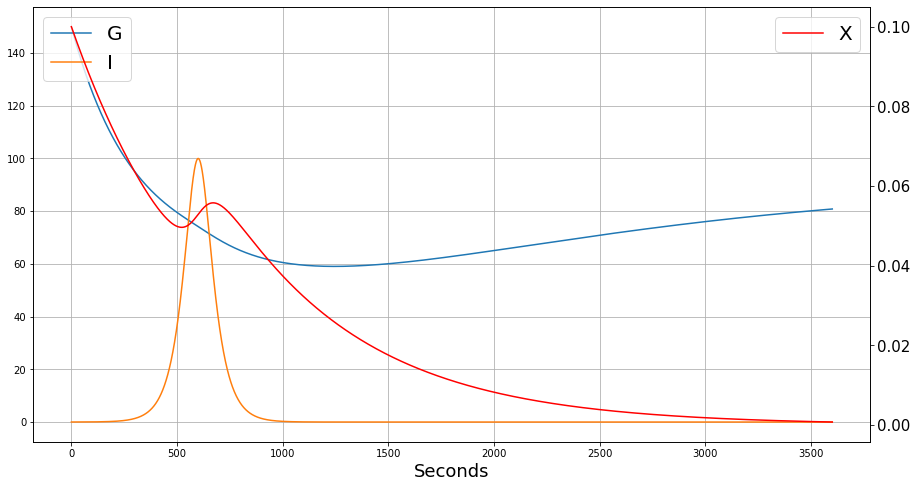

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(G, label='G')
plt.plot(I, label='I')
plt.xlabel('Seconds', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.grid()

ax = ax.twinx()
plt.plot(X, label='X', color='r')

plt.legend(prop={'size': 20})

Let's find error of simulation:


In [8]:
errors = []
coefs_ = np.arange(1, 100, 1)
for coef_ in tqdm(coefs_):
    G1, X1 = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step * coef_)
    errors.append((abs((G - G1[::coef_]) / G)).mean() * 100)

100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


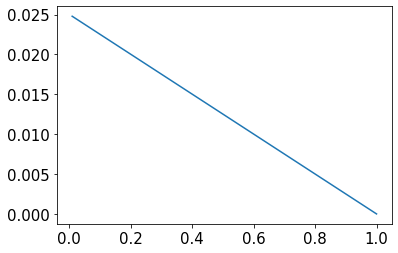

In [9]:
plt.plot(1. / coefs_, errors)

In [10]:
m = LinearRegression().fit((1. / coefs_).reshape(-1, 1), errors)

print("Error:", m.intercept_, "%")

Error: 0.025049976395718182 %


Let's find parameters when we know X and G

p_2, p_3

In [6]:
Y = (X[::step][1:] - X[::step][:-1]) * 1
Z = np.vstack([X[::step][:-1], I[::step][:-1]]).T

model = LinearRegression(fit_intercept=False).fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(0.963565968478838, array([-8.60072601e-02,  8.02783924e-05]), 0.0)

In [7]:
print(model.coef_[0] - p2)
print(model.coef_[1] - p3)

0.004992739899025725
-9.321607589701385e-06


p_1, p_4

In [8]:
Y = (G[::step][1:] - G[::step][:-1]) * 1 + X[::step][:-1] * G[::step][:-1]
Z = G[::step][:-1].reshape(-1, 1)

model = LinearRegression().fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
r2_score(y_pred, Y), model.coef_, model.intercept_

(0.9143070844922452, array([-0.03118913]), 3.2516188856884494)

In [9]:
print(model.coef_[0] - p1)
print(model.intercept_ - p4)

0.017810871128152026
-1.1683811143115506


Let's prove numerically that this problem non-observable. To do so we'll find infinite number parameters for the same G that fit equations

In [10]:
def get_params_basic(p2, p3, G, I, X0, step):
    '''
    For given G, I, p_2, p_3 and X(0) find p_1, p_4 that fit equations and r2_score of that fit
    '''

    X_ = [X0]

    #find X from second equation
    for pos, g in enumerate(G[:-1]):
        dx_dt = p2 * X_[-1] + p3 * I[pos]
        X_.append(X_[-1] + dx_dt / step)

    #find p1, p2, p3 from first equation
    Y = (G[1:] - G[:-1]) * step + X_[1:] * G[1:]
    Z = G[:-1].reshape(-1, 1)

    model = LinearRegression().fit(Z[:], Y[:])
    y_pred = model.predict(Z[:])
           
    return r2_score(y_pred, Y), model.coef_, model.intercept_

def get_params_pro(p2, p3, G, I, X0, step):
    '''
    For given p2, p3, I and G trying to find X0 (close to one that user defined), so r2_score is best
    Print that r2_score and return p_1, p_4
    '''
    grid = np.arange(0, 1.001, 0.05)
    r2_scores = [get_params_basic(p2, p3, G, I,  X0 * coef, step)[0] for coef in grid]
    best_coef = grid[np.argmax(r2_scores)]
    res = get_params_basic(p2, p3, G, I, X0 * best_coef, step)
    print("R2 score of fit:", round(res[0], 4))
    
    return res[1:], X0 * best_coef

Now for different $p_2$ we'll find different $p_1, p_3, p_4$ that fit equations

In [11]:
res = []
for p2_ in np.arange(0.2, 1.001, 0.05) * p2:
    p3_ = p3
    print("p_2={}".format(round(p2_, 4)),end=' ')
    ([p1_,], p4_), X0_ = get_params_pro(p2_, p3_, G[::step], I[::step], X0, 1)
    res.append([p1_, p2_, p3_, p4_, X0_])
res = np.array(res)

p_2=-0.0182 R2 score of fit: 0.9586
p_2=-0.0228 R2 score of fit: 0.9894
p_2=-0.0273 R2 score of fit: 0.9947
p_2=-0.0318 R2 score of fit: 0.9963
p_2=-0.0364 R2 score of fit: 0.997
p_2=-0.0409 R2 score of fit: 0.9973
p_2=-0.0455 R2 score of fit: 0.9972
p_2=-0.05 R2 score of fit: 0.9971
p_2=-0.0546 R2 score of fit: 0.997
p_2=-0.0591 R2 score of fit: 0.9966
p_2=-0.0637 R2 score of fit: 0.9962
p_2=-0.0682 R2 score of fit: 0.9966
p_2=-0.0728 R2 score of fit: 0.9966
p_2=-0.0773 R2 score of fit: 0.9969
p_2=-0.0819 R2 score of fit: 0.998
p_2=-0.0864 R2 score of fit: 0.9965
p_2=-0.091 R2 score of fit: 0.991


Here you can see how parameters change

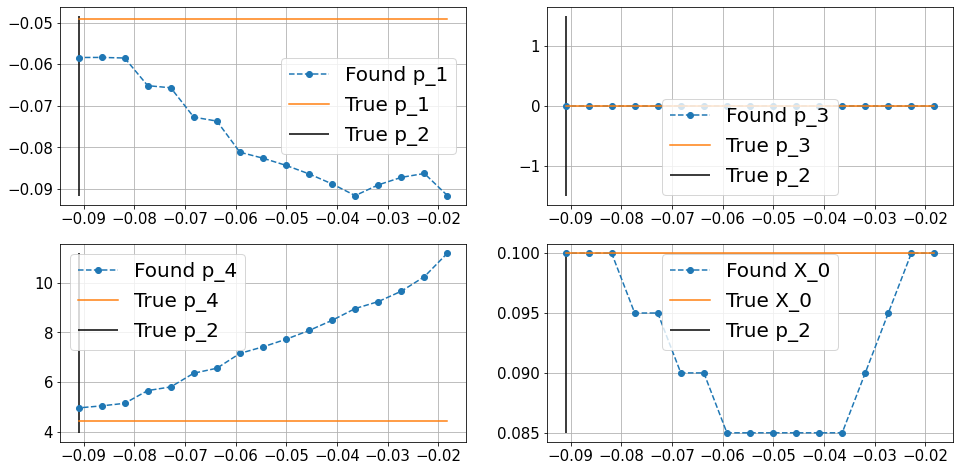

In [12]:
fig = plt.figure(figsize=(16, 8))
# plt.rc('ytick',labelsize=15)
# plt.rc('xtick',labelsize=15)

fig.add_subplot(221)
plt.plot(res[:, 1], res[:, 0], linestyle='--', marker='o', label='Found p_1')
plt.plot(res[:, 1], [p1] * len(res[:, 1]), label='True p_1')
plt.vlines(p2, min(res[:, 0]), max(res[:, 0]) + 0.01, label='True p_2')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(222)
plt.plot(res[:, 1], res[:, 2], linestyle='--', marker='o', label='Found p_3')
plt.plot(res[:, 1], [p3] * len(res[:, 1]), label='True p_3')
plt.vlines(p2, min(res[:, 2]) - 1.5, max(res[:, 2]) + 1.5, label='True p_2')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(223)
plt.plot(res[:, 1], res[:, 3], linestyle='--', marker='o', label='Found p_4')
plt.plot(res[:, 1], [p4] * len(res[:, 1]), label='True p_4')
plt.vlines(p2, min(res[:, 3]) - 1, max(res[:, 3]), label='True p_2')
plt.grid()
plt.legend(prop={'size': 20})

fig.add_subplot(224)
plt.plot(res[:, 1], res[:, 4], linestyle='--', marker='o', label='Found X_0')
plt.plot(res[:, 1], [X0] * len(res[:, 1]), label='True X_0')
plt.vlines(p2, min(res[:, 4]), max(res[:, 4]), label='True p_2')
plt.grid()
plt.legend(prop={'size': 20})
# plt.legend(loc='lower left', prop={'size': 20})

plt.legend(prop={'size': 20})

Accuracy

In [13]:
errors = []
for params in res:
    G1, X1 = find_g(params[0], params[1], params[2], params[3], p5, params[4], I_max, T, step)
    errors.append((abs((G - G1) / G)).mean() * 100)
max(errors)

2.129684779126777

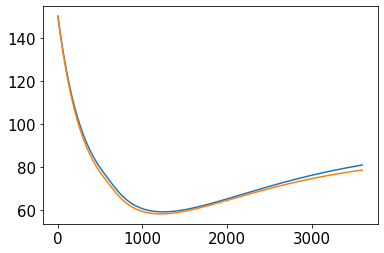

In [14]:
plt.plot(G)
plt.plot(G1)

Let's now show that model is observable

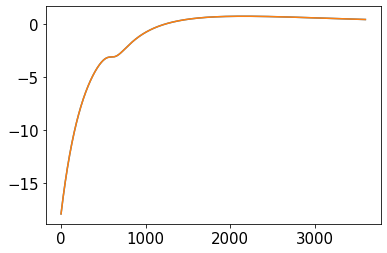

In [25]:
plt.plot((p1 - X) * G + p4)
plt.plot((G[1:] - G[:-1]) * step)

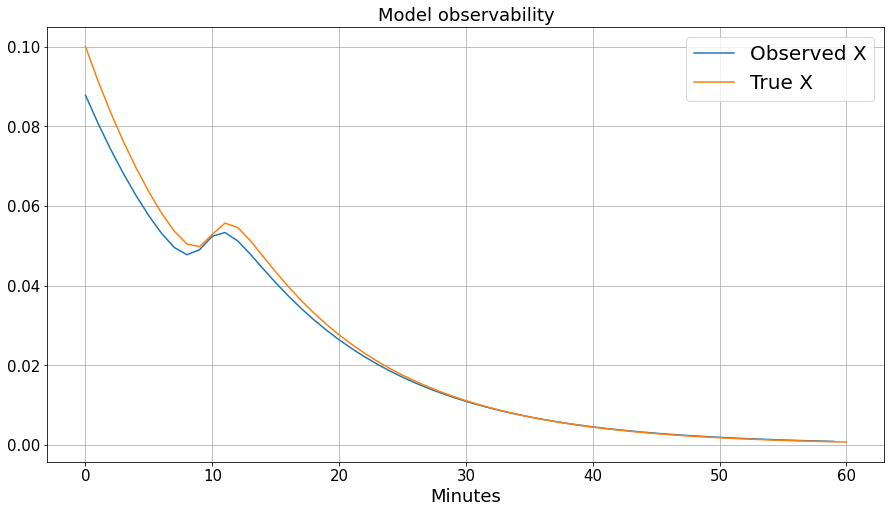

In [27]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.plot(p1 - ((G[::step][1:] - G[::step][:-1]) * 1 - p4) / G[::step][:-1], label='Observed X')
plt.plot(X[::step], label='True X')
plt.xlabel("Minutes", fontsize=18)
plt.title("Model observability", fontsize=18)
plt.grid()
plt.legend(prop={'size': 20})

In [28]:
mape = p1 - ((G[::step][1:] - G[::step][:-1]) * 1 - p4) / G[::step][:-1]
mape = (abs((mape - X[::step][:-1])/ X[::step][:-1])).mean() * 100
print("MAPE:", mape, '%')

MAPE: 4.927544630003928 %


In [31]:
steps = np.arange(1, 60, 1)
errors = []

for step_ in steps:
    pred = p1 - ((G[::step_][1:] - G[::step_][:-1]) * step / step_ - p4) / G[::step_][:-1]
    err = (abs((pred - X[::step_][:-1]) / X[::step_][:-1])).mean() * 100
    errors.append(err)

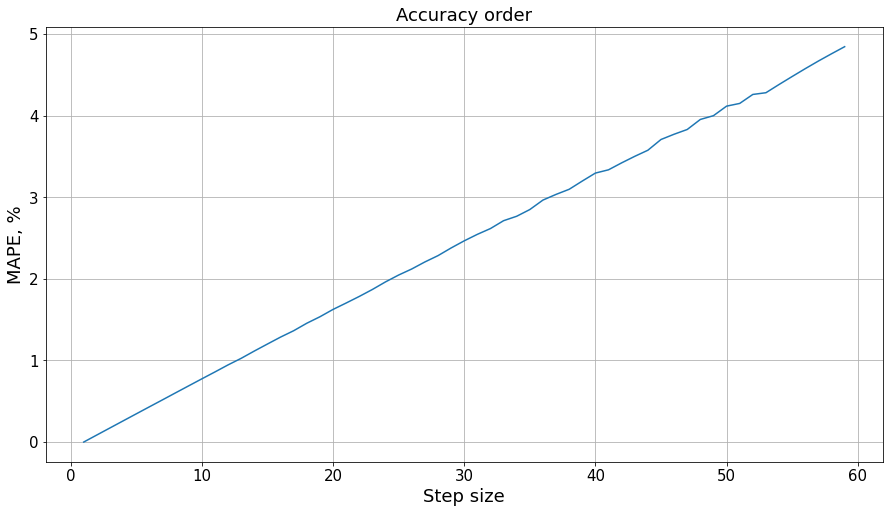

In [32]:
plt.figure(figsize=(15, 8))
plt.rc('ytick',labelsize=15)
plt.rc('xtick',labelsize=15)

plt.xlabel("Step size", fontsize=18)
plt.ylabel("MAPE, %", fontsize=18)
plt.title("Accuracy order", fontsize=18)

plt.grid()
plt.plot(steps, errors)